In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#라이브러리 및 데이터 로딩

In [2]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:2f}".format

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

from datetime import datetime

from itertools import combinations #조합 <> 순열: permutation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as arima
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [3]:
data = pd.read_csv("**")
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
print(data.info(), "\n")
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None 

       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000


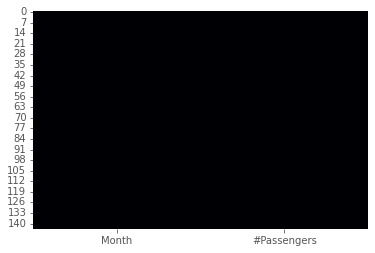

In [5]:
#결측치 확인
sns.heatmap(data.isnull(), cmap="magma", cbar=False)

##전처리

In [6]:
#데이터 유형 변경
data["Month"] = pd.to_datetime(data["Month"])
#컬럼명 변경
data = data.rename(columns={"#Passengers": "Passengers",
                            "Month": "Date"})
#인덱스
data = data.set_index("Date")
data.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#EDA

In [7]:
def test_stationarity(timeseries):
  #plot rolling
  MA = timeseries.rolling(window=12).mean()
  MSTD = timeseries.rolling(window=12).std()

  plt.figure(figsize=(20, 10))
  org = plt.plot(timeseries, "c-", linewidth=2, label="Original")
  ma = plt.plot(MA, "r--", linewidth=2, label="MA")
  mstd = plt.plot(MSTD, "k:", linewidth=2, label="MSTD")

  plt.title("MA & MSTD", size=20)
  plt.xlabel("Year", fontsize=17)
  plt.xticks(fontsize=15)
  plt.legend(loc="best")
  plt.show(block=False);

  #print adfuller
  print("Results of Dickey-Fuller Test:")
  result = adfuller(timeseries, autolag="AIC")
  result_series = pd.Series(result[0:4],
                            index=["Test Statistic", "p-value", "#Lags Used",
                                   "Number of Observations Used"])
  for key, value in result[4].items():
    result_series[f"Critical_value ({key})"] = value

  print(result_series)

In [8]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
  if not isinstance(y, pd.Series):
    y = pd.Series(y)

  with plt.style.context(style):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title(f"Time Series Analysis Plots\n Dickey-Fuller: p-value={p_value:.3f}")

    sm.tsa.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    sm.tsa.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

##현재 상황 시각화

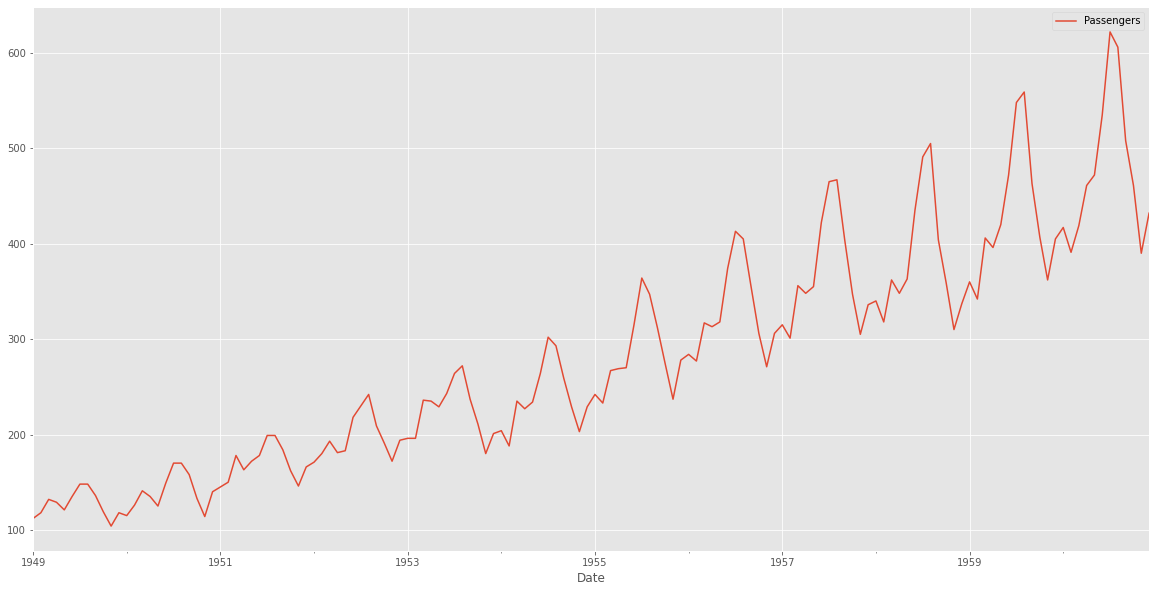

In [9]:
data.plot(figsize=(20, 10))

##seasonal_decompose확인

<Figure size 432x288 with 0 Axes>

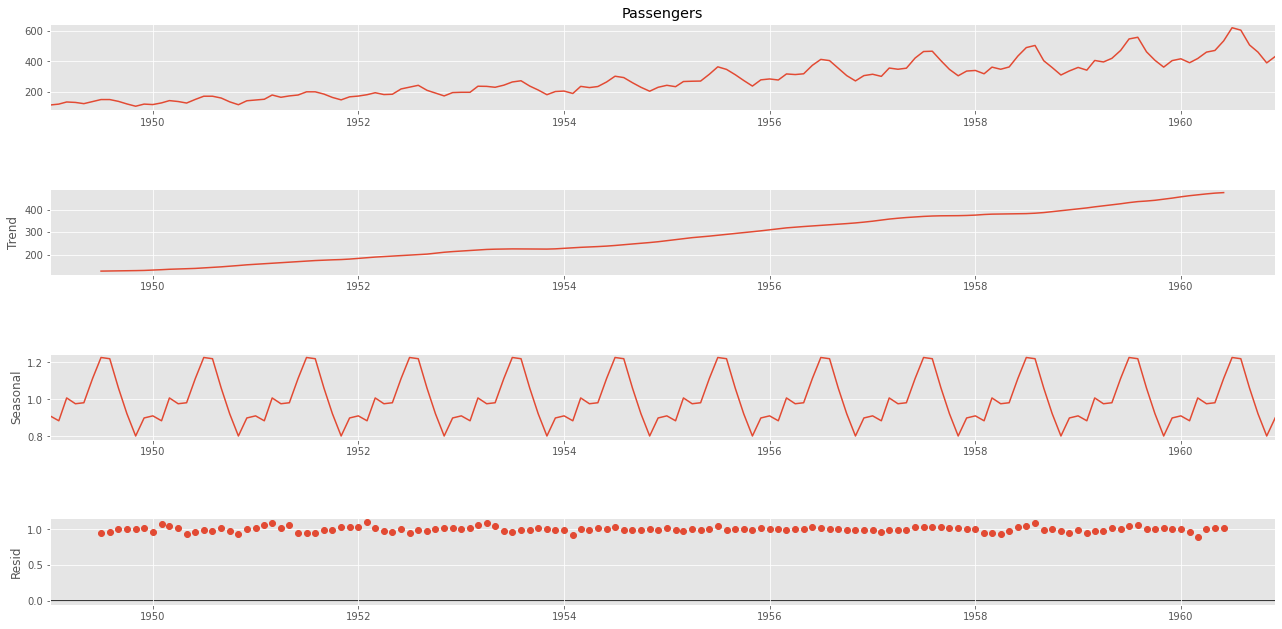

In [10]:
#증가 너비와 폭이 크므로 multiplicative model
dec = smt.seasonal_decompose(data["Passengers"], period=12, model="multiplicative")
fig = plt.figure()
fig = dec.plot()
fig.set_size_inches(20, 10)

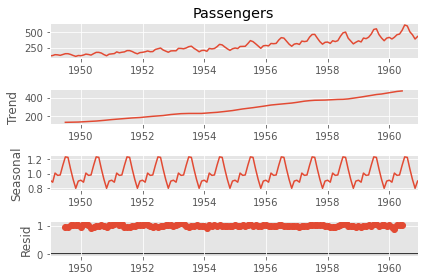

In [11]:
dec = smt.seasonal_decompose(data["Passengers"], period=12, model="multiplicative").plot()
plt.show()

##정상성확인
- Critical Value(5%) > Test statistic
- p-value < .05

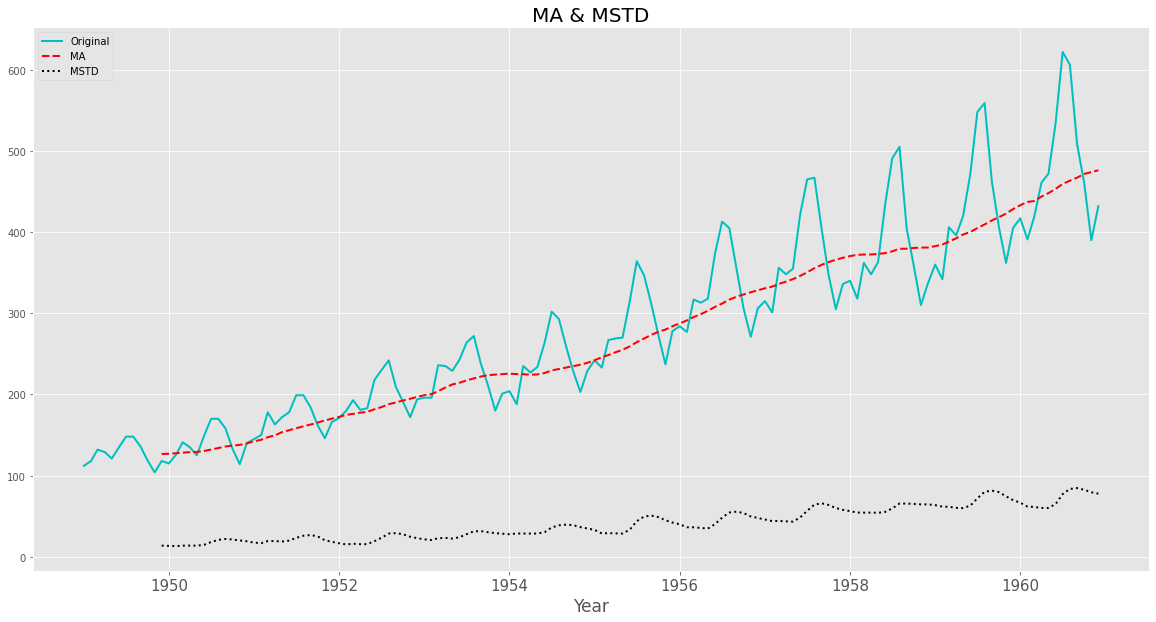

Results of Dickey-Fuller Test:
Test Statistic                  0.815369
p-value                         0.991880
#Lags Used                     13.000000
Number of Observations Used   130.000000
Critical_value (1%)            -3.481682
Critical_value (5%)            -2.884042
Critical_value (10%)           -2.578770
dtype: float64


In [12]:
test_stationarity(data)

- MSTD: 요동친다 > 변동성이 심하다
- critical_value(5%) < Test statistic
- p-value > .05
- 정상성 만족하지 않는다
  - 차분을 통해 정상성 만족시킨다

##차분(1차)

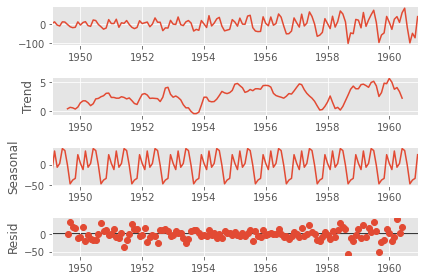

In [13]:
#차분
data_diff = data.diff()
data_diff = data_diff.dropna()

#차분 후 seasonal_decompose확인
dec = smt.seasonal_decompose(data_diff, period=12).plot()
plt.show()

- 차분 후 트렌드 소멸, 값 감소(o)
- 계절성 아직 뚜렷

##차분(1차) 후 정상성 확인
- Critical value(5%) > Test Statistic
- p-value < .05

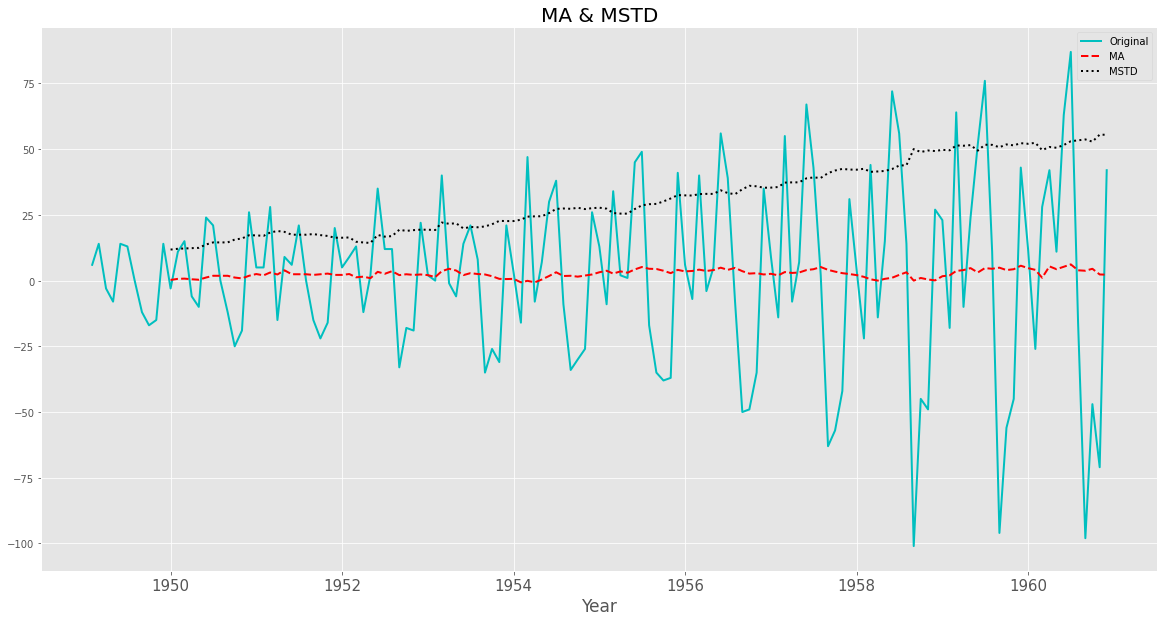

Results of Dickey-Fuller Test:
Test Statistic                 -2.829267
p-value                         0.054213
#Lags Used                     12.000000
Number of Observations Used   130.000000
Critical_value (1%)            -3.481682
Critical_value (5%)            -2.884042
Critical_value (10%)           -2.578770
dtype: float64


In [14]:
test_stationarity(data_diff)

- Critical_value(5%) > Test Statistic(o)
- p-value > .05 (x)
- MA가 0에 가까움
- MSTD는 시간에 따라 증가(불안전)
- 이중차분은 성능저하 가능성
- 정상성을 만족하지 않았지만 위의 시계열 사용


#Modeling

##ARIMA(Auto Regressiv Integrated Moving Average)

- p : 부분 자기 상관(PACF) 그래프가 첫 번째 인스턴스에 대해 잘리거나 0으로 떨어지는 지연 값

- d : 시계열을 정상화하기 위해 차분을 수행한 횟수

- q : 자기상관(ACF) 그래프가 첫 번째 인스턴스에 대한 상위 신뢰 구간과 교차하는 시차 값

###acf, pacf of orginal data
- acf: 시계열과 시차간의 상관관계
- pacf: 시계열과 개별 시차간의 상관관계

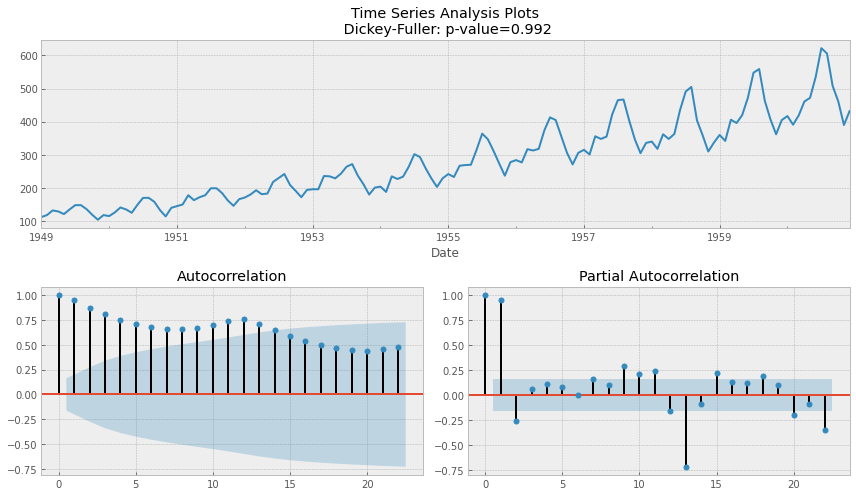

In [15]:
tsplot(data["Passengers"])

- pacf: 첫번째 시차는 신뢰 구간을 벗어남

### acf, pacf of diff data

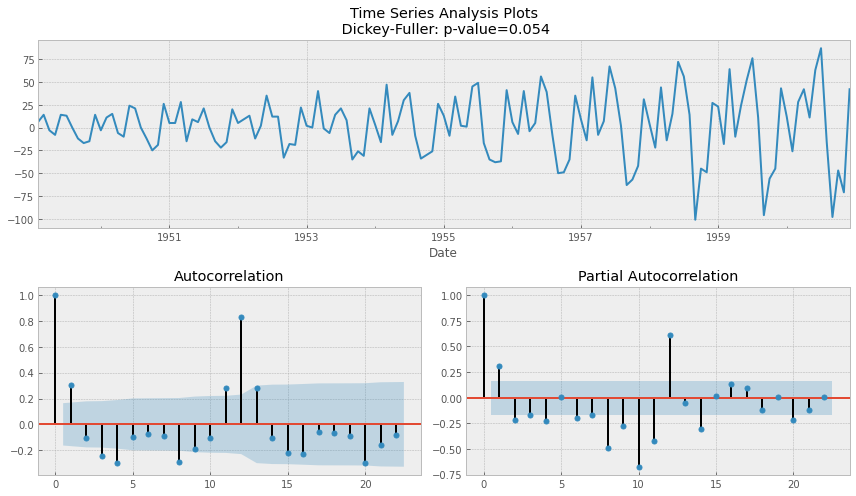

In [16]:
tsplot(data_diff["Passengers"])

- pacf(p): 3번째 시점에서 신뢰구간과 교차 > 3-1 = 2
- acf(q): 2번째 시점에서 신뢰구간과 교차


###모델 정의

In [17]:
#p=2, d=1, q=2로 모델 생성
model = arima(data["Passengers"], order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -666.022
Method:                       css-mle   S.D. of innovations             24.716
Date:                Mon, 14 Nov 2022   AIC                           1344.043
Time:                        00:29:59   BIC                           1361.821
Sample:                    02-01-1949   HQIC                          1351.267
                         - 12-01-1960                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5311      0.708      3.574      0.000       1.143       3.919
ar.L1.D.Passengers     1.6477      0.033     49.931      0.000       1.583       1.712
ar.L2.D.Passengers  

###데이터 분리, 학습, 예측
- 30개를 test데이터로
- 나머지를 train데이터로
- train값을 리스트로 저장
- test데이터 수만큼 학습 > 반복 1번에 train데이터 모두 학습
  - 예측값 추출

In [18]:
size = int(len(data)-30)
train, test = data["Passengers"][:size], data["Passengers"][size:len(data)]

print("\t ARIMA Model: In- Sample Forecating \n")

history = [x for x in train]
print(history)
predictions = []

for t in range(len(test)):
  model = arima(history, order=(2, 1, 2))
  model_fit = model.fit(disp=0)

  output = model_fit.forecast() #예측값들
  yhat = output[0] #0번째가 예측값
  predictions.append(float(yhat))
  
  obs = test[t] #test 슬라이싱한 values
  history.append(obs)

  print(f"predicted={yhat}, expected={obs}") #예측값과 실제값 비교

print(history)
  # yhat = output[0]
  # predictions.append(float(yhat))

	 ARIMA Model: In- Sample Forecating 

[112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193, 181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235, 229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234, 264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315, 364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413, 405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467, 404, 347, 305, 336, 340, 318, 362, 348, 363, 435]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=[433.25720746], expected=491
predicted=[478.35632142], expected=505
predicted=[474.55258818], expected=404
predicted=[367.68687929], expected=359
predicted=[386.04545863], expected=310
predicted=[300.55169627], expected=337
predicted=[342.709379], expected=360
predicted=[374.43436529], expected=342
predicted=[368.41871221], expected=406
predicted=[427.29383842], expected=396
predicted=[416.58053562], expected=420
predicted=[431.95238811], expected=472
predicted=[465.57483831], expected=548
predicted=[516.13390374], expected=559


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=[522.64225836], expected=463
predicted=[407.12282424], expected=407
predicted=[367.58174929], expected=362
predicted=[349.94171978], expected=405
predicted=[415.81755873], expected=417
predicted=[443.40792272], expected=391
predicted=[432.87734343], expected=419
predicted=[467.78841024], expected=461
predicted=[505.28867526], expected=472
predicted=[505.20830328], expected=535
predicted=[548.6779296], expected=622
predicted=[603.21477328], expected=606
predicted=[560.80747218], expected=508
predicted=[458.42339836], expected=461
predicted=[419.51352211], expected=390
predicted=[373.83442053], expected=432
[112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193, 181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235, 229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234, 264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 2

### 원래 값과 예측값 비교

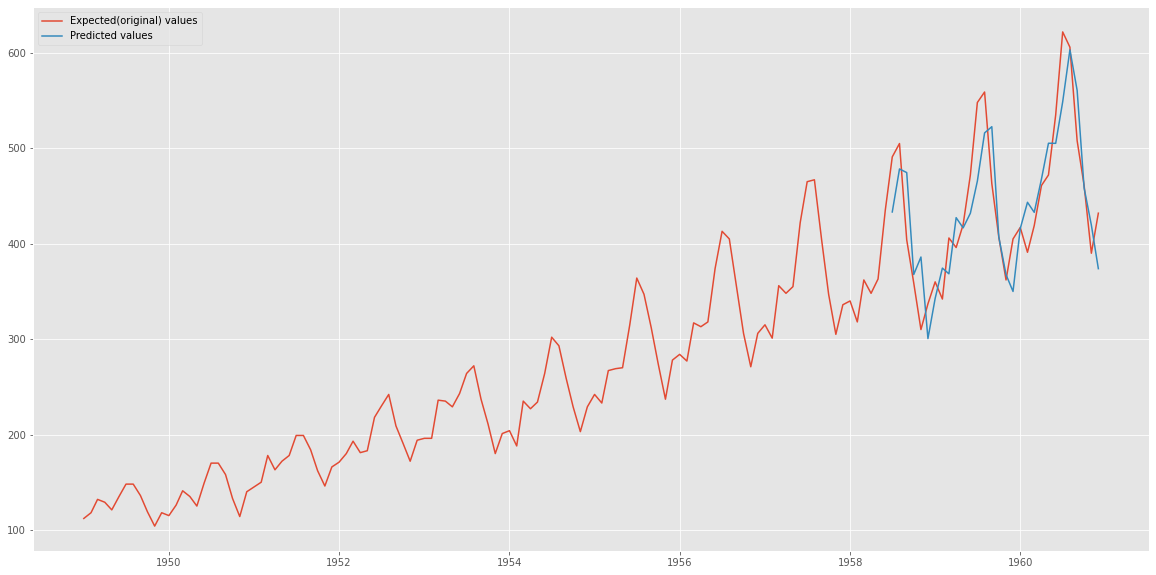

In [19]:
#시각화
predictions_series = pd.Series(predictions, index=test.index)
predictions_series

plt.figure(figsize=(20, 10))
plt.plot(data["Passengers"], label="Expected(original) values")
plt.plot(predictions_series, label="Predicted values")
plt.legend(loc="upper left")
plt.show()

In [20]:
#rmse
error = np.sqrt(mean_squared_error(test, predictions))
print(f"Test RMSE: {error:.4f}")

Test RMSE: 42.5181


- test rmse의 값이 높음
- 모델의 순서 뿐만 아니라 계절성의 존재도 성능에 영향을 미쳤을 가능성 있음
- Out-of-sampling 실시

###Out of sampling(df1, forecast dataframe 생성)
- data의 전체 index(date)를 사용하여 index외 date의 value를 예측

In [21]:
from pandas.tseries.offsets import DateOffset

In [22]:
max(data.index)

Timestamp('1960-12-01 00:00:00')

In [23]:
#orginal 데이터의 max날짜 + 48주 데이터 생성
future_dates = [data.index[-1] + DateOffset(weeks=x) for x in range(0, 49)]
print(len(future_dates))
print(future_dates[:6])

#미래 값이 담길 새로운 데이터 프레임 생성
df1 = pd.DataFrame(index=future_dates[1:], columns=data.columns)
df1.head()

forecast = pd.concat([data, df1], axis=0) #새로운 날짜 이어붙이기
forecast["ARIMA_Forecast_Function"] = np.NaN #예측값 저장할 열
forecast["ARIMA_Predict_Function"] = np.NaN #예측값 저장할 열
forecast.head()

49
[Timestamp('1960-12-01 00:00:00'), Timestamp('1960-12-08 00:00:00'), Timestamp('1960-12-15 00:00:00'), Timestamp('1960-12-22 00:00:00'), Timestamp('1960-12-29 00:00:00'), Timestamp('1961-01-05 00:00:00')]


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


####Forecast_Function

In [24]:
ARIMA_history_f = [x for x in train] #orginal train values
f1 = []

#새롭게 예측할 값 만큼 반복
for t in range(len(df1)):
  model = arima(ARIMA_history_f, order=(2, 1, 2))
  model_fit = model.fit(disp=0)

  output = model_fit.forecast()[0][0]
  ARIMA_history_f.append(output) #원래 train값 뒤에 새로운 예측값 추가
  f1.append(output) #새로운 예측값 저장

#값 업데이트
for i in range(len(f1)):
  forecast.iloc[144+i, 1] = f1[i]

forecast.tail()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1961-10-05,NaN,490.801497,NaN
1961-10-12,NaN,493.308002,NaN
1961-10-19,NaN,495.814785,NaN
1961-10-26,NaN,498.321883,NaN
1961-11-02,NaN,500.828520,NaN


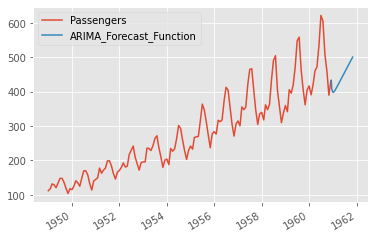

In [25]:
forecast[["Passengers", "ARIMA_Forecast_Function"]].plot();

- forecast_function에 의해 생성된 값이 상승하고 있음

#### Predict_Function

In [26]:
Arima_history_p = [x for x in train] #train 값 저장
f2 = []

#새로 생긴 날짜 만큼 반복
for i in range(len(df1)):
  model = arima(Arima_history_p, order=(2, 1, 2))
  model_fit = model.fit(disp=0)

  output = model_fit.predict(start=len(Arima_history_p), end=len(Arima_history_p),
                             typ="levels")[0]
  Arima_history_p.append(output)
  f2.append(output)

for i in range(len(f2)):
  forecast.iloc[144+i, 2] = f2[i]

forecast.tail()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1961-10-05,NaN,490.801497,490.801497
1961-10-12,NaN,493.308002,493.308002
1961-10-19,NaN,495.814785,495.814785
1961-10-26,NaN,498.321883,498.321883
1961-11-02,NaN,500.828520,500.828520


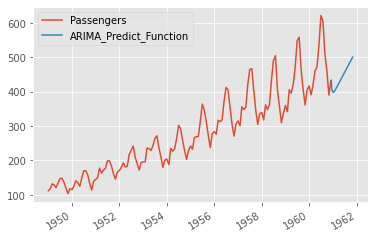

In [27]:
forecast[["Passengers", "ARIMA_Predict_Function"]].plot()

####compare Forecast Function and Predict Function

In [28]:
sum(f1) == sum(f2)

True

- 훈련된 ARIMA모델의 경우 예측기능과 예측기능에 의해 생성된 값들은 정확히 동일
- 모델이 데이터의 계절적 패턴을 분명히 포착하지 못한것으로 보임

##SARIMA(Seasonal Auto Regressive Integrated Moving Average)
- 데이터의 계절 효과를 처리할 수 있는 ARIMA모델의 확장
- (p, d, q) * (P, D, Q, M)이 있음
- (p, d, q)는 ARIMA 모델의 차수와 유사
- 계절적 주기나 주기의 빈도(M)를 구별하여 계절성을 처리하고 M번째 시차 값에서 ACF, PACF값 확인

### 차분
- 1년으로 진행(12개월)

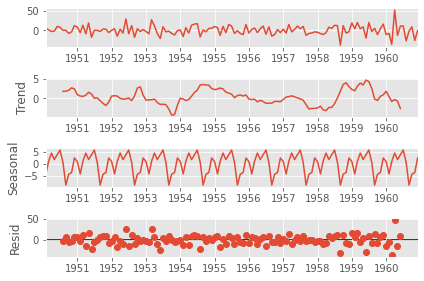

In [32]:
#차분
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()

#차분 후 계절성 확인
dec = sm.tsa.seasonal_decompose(data_diff_seas, period=12)
dec.plot()
plt.show()

###차분 후 정상성 확인

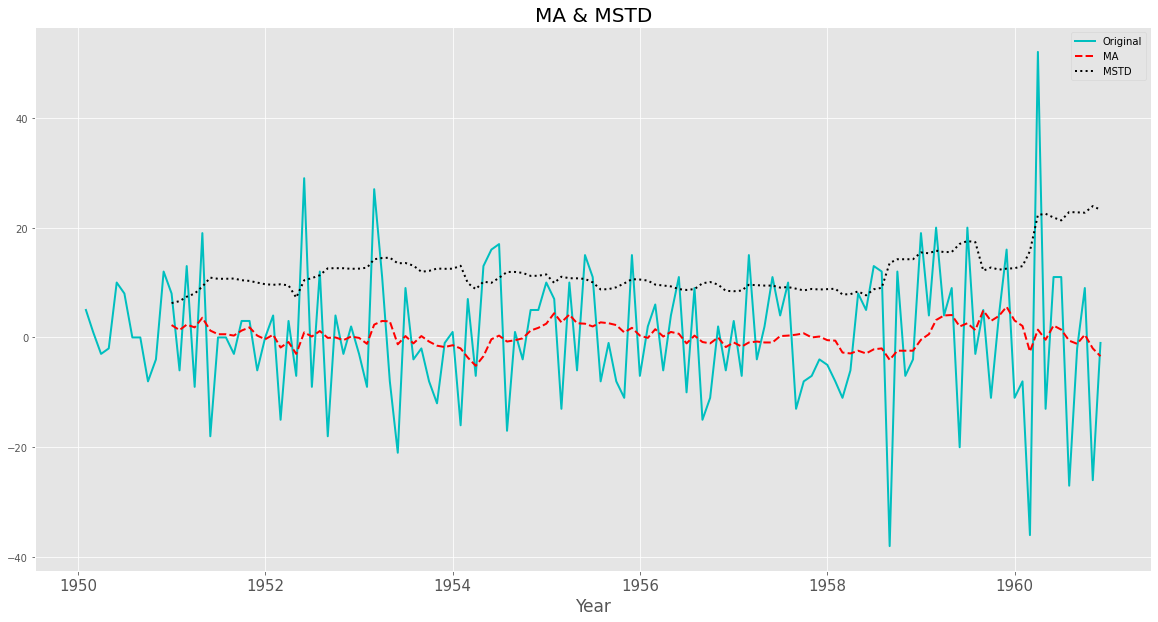

Results of Dickey-Fuller Test:
Test Statistic                -15.595618
p-value                         0.000000
#Lags Used                      0.000000
Number of Observations Used   130.000000
Critical_value (1%)            -3.481682
Critical_value (5%)            -2.884042
Critical_value (10%)           -2.578770
dtype: float64


In [33]:
test_stationarity(data_diff_seas["Passengers"])

- Critical_value(5%) > Test Statistic(o)
- p-value < .05 (o)
- 시계열 정상적이라고 판단

###acf, pacf of diff seasonal data

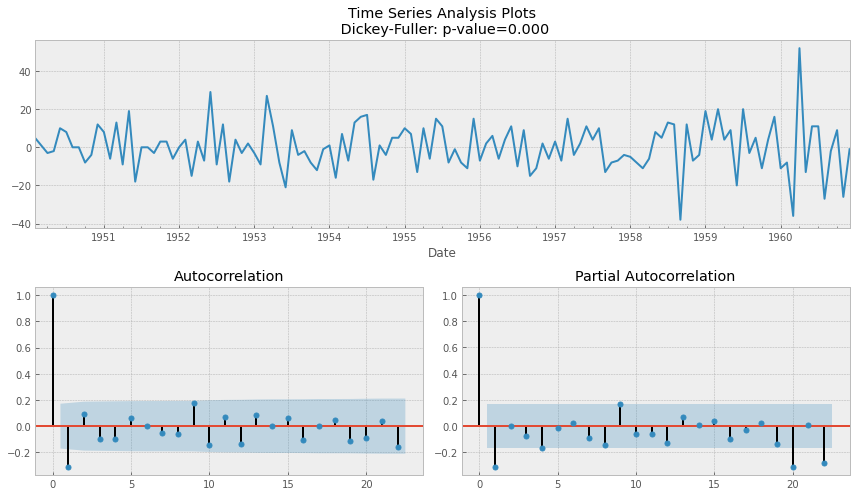

In [34]:
tsplot(data_diff_seas["Passengers"])

- M: 12(계절성 12개월 주기)
- pacf(p): 0
- d: 1
- acf(q): 1


###모델 정의

In [35]:
model = sm.tsa.statespace.SARIMAX(data["Passengers"],
                                  order=(2, 1, 2),
                                  seasonal_order=(0, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -503.968
Date:                              Mon, 14 Nov 2022   AIC                           1019.935
Time:                                      00:57:16   BIC                           1037.186
Sample:                                  01-01-1949   HQIC                          1026.945
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3966      0.422      0.940      0.347      -0.430       1.223
ar.L2          0.35

###데이터분리, 학습, 예측

In [39]:
#데이터분리
size = int(len(data) - 30)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

#train values
history = [x for x in train]
predictions = []

for t in range(len(test)):
  #모델정의
  model = sm.tsa.statespace.SARIMAX(history,order = (2,1,2),seasonal_order = (0,1,1,12))
  model_fit = model.fit() #학습
  
  output = model_fit.forecast() #예측값, 예측의 표준오차, 신뢰구간
  
  yhat = output[0]#예측값
  predictions.append(float(yhat)) #예측값 저장
  
  obs = test[t] #test values
  history.append(obs) #train values + test_values
  
  print('predicted = %f, expected = %f' % (yhat, obs))  

	 SARIMA MODEL : In - Sample Forecasting 

predicted = 479.083943, expected = 491.000000
predicted = 490.553509, expected = 505.000000
predicted = 441.276123, expected = 404.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted = 357.273139, expected = 359.000000
predicted = 315.250905, expected = 310.000000
predicted = 347.832938, expected = 337.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted = 344.249304, expected = 360.000000
predicted = 336.836110, expected = 342.000000
predicted = 387.592045, expected = 406.000000
predicted = 387.333487, expected = 396.000000
predicted = 408.192790, expected = 420.000000
predicted = 485.988159, expected = 472.000000
predicted = 529.031344, expected = 548.000000
predicted = 551.914009, expected = 559.000000
predicted = 459.061273, expected = 463.000000
predicted = 411.970100, expected = 407.000000
predicted = 358.421152, expected = 362.000000
predicted = 384.945729, expected = 405.000000
predicted = 420.143844, expected = 417.000000
predicted = 397.755392, expected = 391.000000
predicted = 451.335525, expected = 419.000000
predicted = 415.675162, expected = 461.000000
predicted = 465.295951, expected = 472.000000
predicted = 529.835409, expected = 535.000000
predicted = 599.299657, expected = 622.000000
predicted = 626.292198, expected = 606.000000
predicted = 513.891978, expected = 508.000000
predicted = 450.136743, expected =

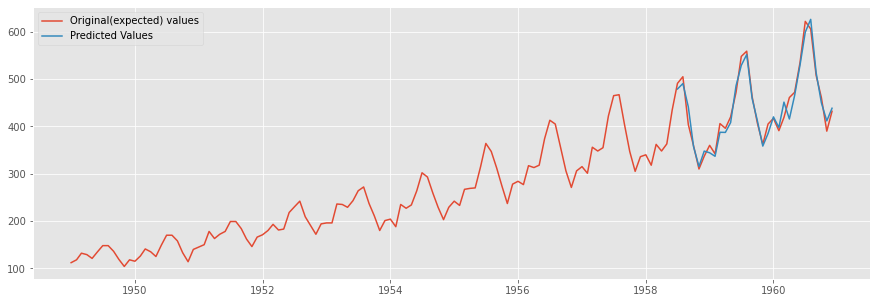

In [41]:
predictions_series = pd.Series(predictions, index=test.index)

plt.figure(figsize=(15, 5))
plt.plot(data["Passengers"], label="Original(expected) values")
plt.plot(predictions_series, label="Predicted Values")
plt.legend(loc="upper left")
plt.show();

###원래값과 예측값 비교

In [43]:
error = np.sqrt(mean_squared_error(test, predictions))
print(f"Test RMSE: {error:.4f}")

Test RMSE: 16.9253


- ARIMA보다 SARIMA의 RMSE값이 낮은 것을 알 수 있다.
- SARIMA: 계절성을 제외시키고 분석)

###Out of sampling
- data의 전체 index(date)를 사용하여 index외 date의 value를 예측

In [48]:
forecast["SARIMA_Forecast_Function"] = np.NaN
forecast["SARIMA_Predict_Function"] = np.NaN
forecast.head()

,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,NaN,NaN
1949-03-01,132,NaN,NaN,NaN,NaN
1949-04-01,129,NaN,NaN,NaN,NaN
1949-05-01,121,NaN,NaN,NaN,NaN


#### Forecast_Function
- train으로 미래값 예측

In [50]:
len(train)

114

In [53]:
SARIMA_history_f = [x for x in train] #train values
f3 = []

#새로만든 날짜만큼 반복
for t in range(len(df1)):
  model = sm.tsa.statespace.SARIMAX(SARIMA_history_f,
                                   order=(2, 1, 2),
                                   seasonal_order=(0, 1, 1, 12))
  model_fit = model.fit()
  output = model_fit.forecast()[0]

  SARIMA_history_f.append(output) #train values + output
  f3.append(output)

for i in range(len(f3)):
  forecast.iloc[144+i, 3] = f3[i]
forecast.tail()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1961-10-05,NaN,490.801497,490.801497,423.785083,NaN
1961-10-12,NaN,493.308002,493.308002,469.381111,NaN
1961-10-19,NaN,495.814785,495.814785,456.602004,NaN
1961-10-26,NaN,498.321883,498.321883,471.067918,NaN
1961-11-02,NaN,500.828520,500.828520,542.691823,NaN


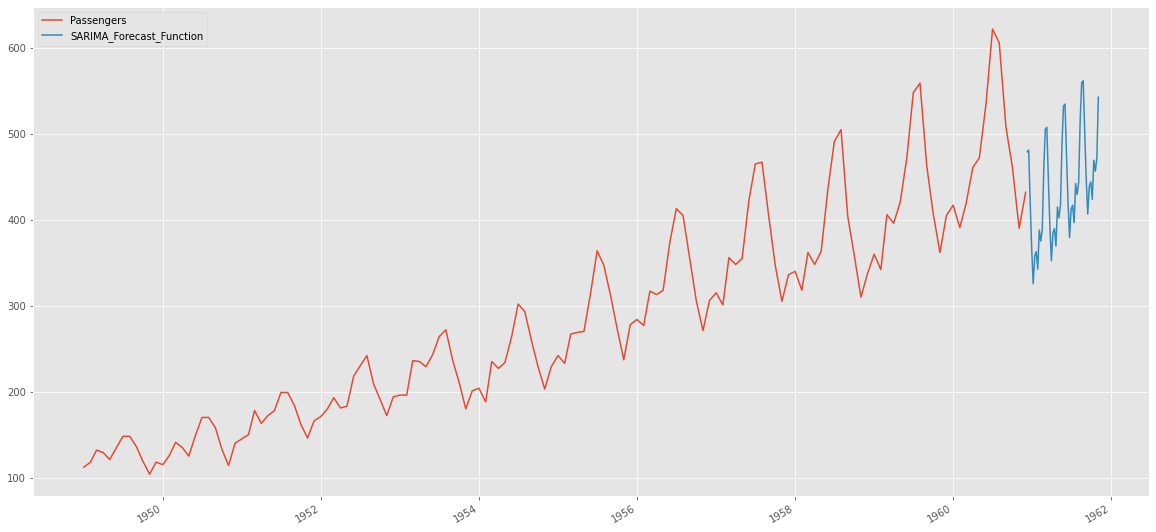

In [54]:
forecast[["Passengers", "SARIMA_Forecast_Function"]].plot(figsize=(20, 10))

- 계절적 패턴을 인식하고 예측함
- 하지만 계절적 패턴의 폭(multiplicative: seasonal_decompose의 파라미터(model))은 인식하지 못함

####Predict_Function

In [57]:
SARIMA_history_p = [x for x in train]
f4 = []

for t in range(len(df1)):
    
    model = sm.tsa.statespace.SARIMAX(SARIMA_history_p,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.predict(start = len(SARIMA_history_p), end = len(SARIMA_history_p),typ = 'levels')[0]
    
    SARIMA_history_p.append(output)
    f4.append(output)
    
for i in range(len(f4)):
    forecast.iloc[144 + i,4] = f4[i]
forecast.tail()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1961-10-05,NaN,490.801497,490.801497,423.785083,423.785083
1961-10-12,NaN,493.308002,493.308002,469.381111,469.381111
1961-10-19,NaN,495.814785,495.814785,456.602004,456.602004
1961-10-26,NaN,498.321883,498.321883,471.067918,471.067918
1961-11-02,NaN,500.828520,500.828520,542.691823,542.691823


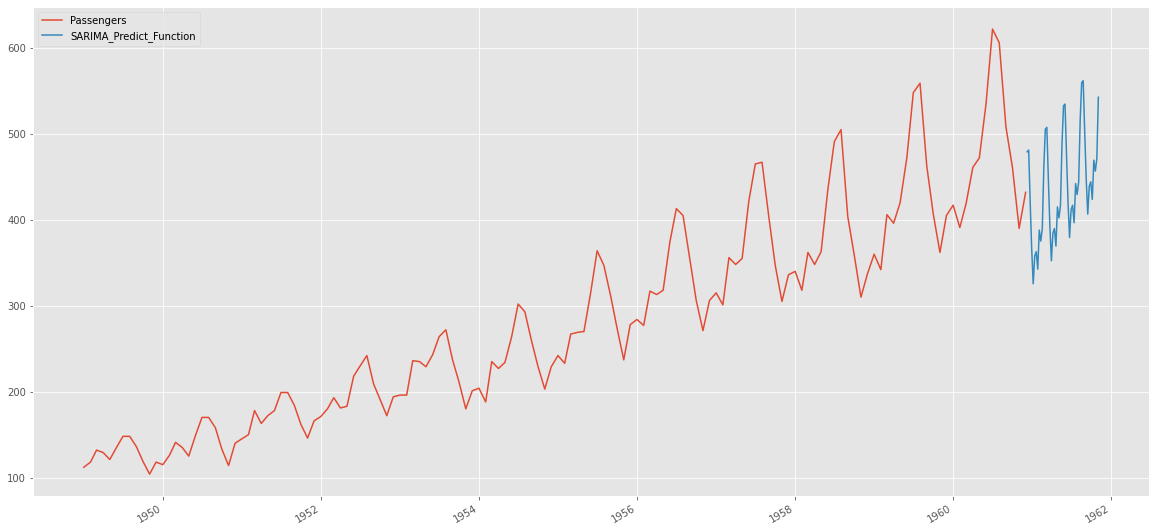

In [58]:
forecast[["Passengers", "SARIMA_Predict_Function"]].plot(figsize=(20, 10))

#### compare Forecast Function and Predict Function

In [59]:
sum(f3) == sum(f4)

True

- 두 값이 동일하다

#Conclusion

- ARIMA 모델보다 SARIMA 모델의 RMSE가 낮다.
- SARIMA의 계절성 제거를 통해 모델의 정확도가 올라갔다.
- SARIMA를 사용해도 계절성의 폭을 반영할 수 없다.